<a href="https://colab.research.google.com/github/nspeer12/AI_CAP4630/blob/master/hw4.3.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Xception

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the Xception model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-18 00:21:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   110MB/s    in 0.6s    

2020-04-18 00:21:48 (110 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Xception Model
Xception is convolutional neural network model developed by François Chollet. It is based on the already performant Inception model. Xception performs a number depthwise separable convolutions [1]. With a 94.5% accuracy on ImageNet classifications, Xception slightly, but significantly outperforms its predecessor, Inception-v3 at 94.1% accuracy [2]. 

### Depthwise Convolutions

Depthwise in the realm of images and computer vision would be equivalent to the RGB channels of an image. Depthwise convolutions involve a kernel for each separate channel of the input. The resulting output has the same depth as the input.

### Seperable Convolutions

Separable convolutions are an operation in which not one, but two or more kernels are applied to an input matrix. Each separable convolution produces an intermediate matrix that is able to be convoluted by the next kernel. 


Source: [1]


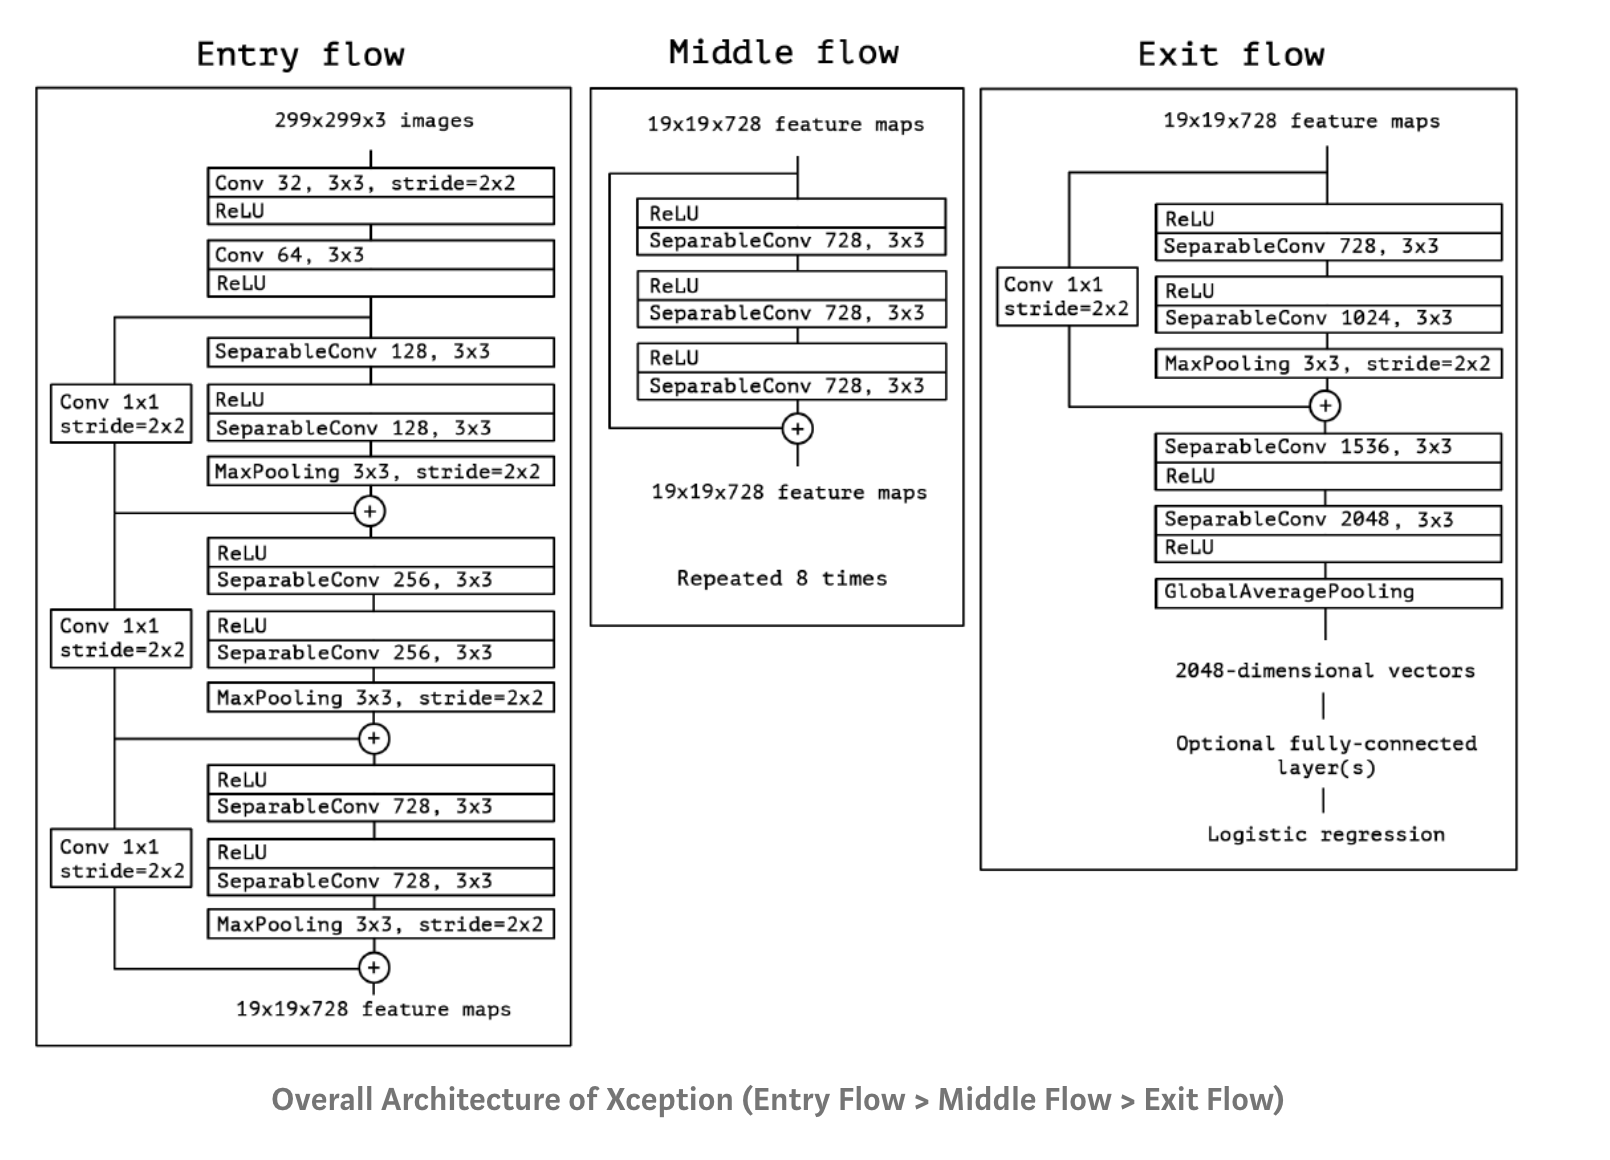

## Build network with Xception convolution base and custom densely connected layers

### Load the convolutional base

In [4]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


83689472/83683744 [==============================] - 7s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)

# flatten output of convolutional model and add a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

# dropout layer to preent overfitting
model.add(layers.Dropout(.1))

model.add(layers.Dense(64, activation='relu'))

# logistic regression layer
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 47,109,289
Trainable params: 26,247,809
Non-trainable params: 20,861,480
_________________________________

## Train the model end to end with frozen convolutional base

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 29s 293ms/step - loss: 0.4768 - acc: 0.7550 - val_loss: 0.1619 - val_acc: 0.9440
Epoch 2/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3749 - acc: 0.8265 - val_loss: 0.0422 - val_acc: 0.9700
Epoch 3/30
100/100 [==============================] - 19s 190ms/step - loss: 0.3544 - acc: 0.8345 - val_loss: 0.0050 - val_acc: 0.9600
Epoch 4/30
100/100 [==============================] - 19s 190ms/step - loss: 0.3455 - acc: 0.8435 - val_loss: 0.3496 - val_acc: 0.9510
Epoch 5/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3367 - acc: 0.8530 - val_loss: 2.2014e-05 - val_acc: 0.9630
Epoch 6/30
100/100 [==============================] - 19s 190ms/step - loss: 0.3135 - acc: 0.8610 - val_loss: 4.3165e-05 - val_acc: 0.9710
Epoch 7/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3407 - acc: 0.8345 

## Display curves of loss and accuracy during training

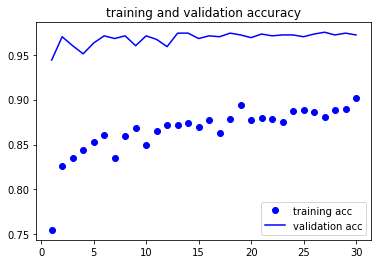

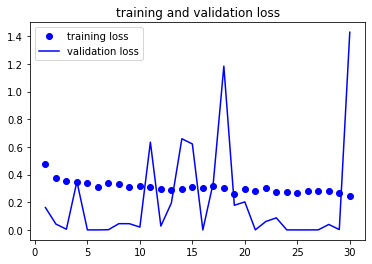

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [11]:
# compile model

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=1e-5), 
    metrics=['acc'])

# train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 220ms/step - loss: 0.2825 - acc: 0.8805 - val_loss: 0.3045 - val_acc: 0.9440
Epoch 2/100
100/100 [==============================] - 19s 187ms/step - loss: 0.2659 - acc: 0.8910 - val_loss: 0.1676 - val_acc: 0.9240
Epoch 3/100
100/100 [==============================] - 19s 191ms/step - loss: 0.2370 - acc: 0.8920 - val_loss: 0.1418 - val_acc: 0.9370
Epoch 4/100
100/100 [==============================] - 19s 191ms/step - loss: 0.2592 - acc: 0.8925 - val_loss: 0.0295 - val_acc: 0.9340
Epoch 5/100
100/100 [==============================] - 19s 189ms/step - loss: 0.2315 - acc: 0.9005 - val_loss: 0.2573 - val_acc: 0.9290
Epoch 6/100
100/100 [==============================] - 19s 190ms/step - loss: 0.2386 - acc: 0.8950 - val_loss: 0.0910 - val_acc: 0.9370
Epoch 7/100
100/100 [==============================] - 19s 190ms/step - loss: 0.2211 - acc: 0.9070 - val_loss: 0.1112 - val_acc: 0.9360
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

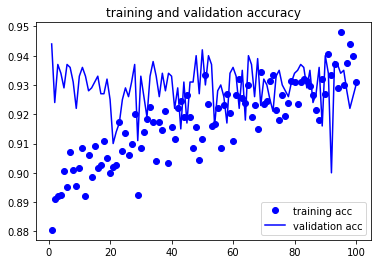

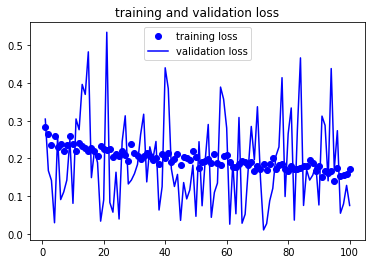

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [14]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.39762404561042786
Validation accuracy: 0.9300000071525574


# Save the model

In [18]:
model_fname = 'xception_512_62.h5' 
model.save(model_fname)

from google.colab import files

with open(model_fname, 'w') as f:
  files.download(model_fname)

MessageError: ignored

# Animal Testing

These are my animals

## Pumpkin

Pumpkin has an attitude. She's a diva to say the least. She's also very sweet, and makes a great office assistant, but she makes a lot of typos when walking over the keyboard.

## Chief

Chief is no longer with us. He was the sweetest dog in the whole world. He weighed a whopping 120 lbs and was massive. He loves the beach and playing fetch. He loved eating any kind of meat, and suprisingly brocolli and tomatoes too.

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from urllib.request import urlopen

urls = ['https://lh3.googleusercontent.com/4P_V2DypwxdSSf_qbLLWWdymcrEoSInM3cGgCcQXrt2-ESPEGPMBnb4NpVUsw39ZMB6DhZAHOuwdjSNvd66irQB76HF2EKhi-hbf2Wsr29RlvuYW19PhiCBpvrDgYc39CLyimWx2NiLzbiHql8TongEzTlsypa0Qzkbb3QArfuFWEErLvKqDkjUePaSy1IOifosgbq3DKKRq9ju1S2x1Au0EA2hbz34niYXsHXDLYxlbPiOUvgOn7zMg6_k-T-Dv2Z0Nm-1OxYYc2hCjWaQ6B-2p6yONORQUDpBh7MGOUT15bfLm4sHIA3EMY4pC2vIODlGAvLN7Bdl5rVkCKcDjpd4qrC1_vhm6FogCBzeDMUpOY9hxszF25j0oAXbb-lsy6eAkIyLLq6JjOuQ4gtrqMkyfyYWAZudNAwdVKxgfJK2UiseEGH_ThsXevUFOpfDlje6QrvLTrZL_V711fRBdjg-Hf3CsNvWSJDTfFAoUvH2hr73nbqeYmXKPfGqvfOEfObjEUwPEH3acK_7zljvw-vt1lRWi1Yv2ZHUyF3TD8jR98mb6h_RmOuRAuKC2NfxUskBo1kFhgHxyaFB40GU7n9QD9KaGBiF6k4M1Ql2cZTcI6M_FSqv3m_vSlK7jt1cD1vC_x6CscMDQHiJeJ-4ZV697hd90PEnSWu2yapYzzQL3Fl4vuceprcs3qBSm-wc=s150-no',
        'https://lh3.googleusercontent.com/tIg83pQ9BY0TUOwxmbNWQMPOOx1eTItdDn069J2urfUAypFMH7SEYyx7Qnbt_O5w-06WD8ltAq7ecOKrmjwgaNpeIX5TJB8KHCVYASjI3v1Z7f4ZcAZzk7ci3T5tcPYiWeFfOYBWRS2rCFXlAPRVkkWNdo2_HN-RaQLJI0LGeJCXNirzEvZoQLTOYZZiA4_ESVEvId06y54-DtjWhePfy49rzyynCasdGxntMi_FS3by3yiIjgMJ7QxnPp7253-zAkMiyR38nTD7iDrsIw9emjSC6_SIn7WHL0IW_RSlfLbFTD25uKM8l7kbHlrmimlB77uldUtM8MXyzWhZ9aMEam-yFi6B6H7QkI164CNqtRoeW5h_y4xKo0crGzJuOFI_EmwQWizXpIM0VDr1RHhLNNDVBDcI1KP42QGhsspyZUFfRBZWZcjLcfdJ9klEbsedZD-FTFNMCQWlVY_vS5dv-wUFuqgxdvkBPKfUYEcPOpye7QqbWvrce07NATokrCEav5Z2huhfOfFzhlPfSqoQnzH-9WW6Egd4oLdobnJcIcJHDciWztv46PgV9kod_0axDL0DvC4BNRALOW_3_SZYEMlL6Bt5hhUZ9YFhxttgA_gRlKtnAp8_LBhy5euibQhsAi9tFc8AME93FNbSba7aJtn3sNoMnXXOaS4U1Xl3bP4LsOisEiKC9QzYQzEAWb0=s150-no',
        'https://lh3.googleusercontent.com/8ss13LyL1_lDKMngdkcSJaAxislC-CrZtb4faR27OWTk5wOMz71ou4t5i7R2O_7s4YRQro_XKk3fYEJaEA3kVTFVwbPZBNLcXOuUEwtXwa6e2JfiCFmVTGrM979m1wyjnTZ8dhNzFd7r81Jw-KKg09SoKQ250wykEX74-xan4kqDxYnWxRE9beiDz5yePldwWsc0IAPKXSnE084M1Bg6diuPenJ_u9vZgbOTDpiArvGYa2T97AcN8SwuDdkfcKcKtyT9T71zjh7SFZnz9my-KR2wzMWtrZ2LIzRc63tUNePAuy9B9bgFj3N74QpLQAPjpbkIqhoNbhSQVoAI0q_Ln85ORoGQCHDKQAw02UgcLKLiCDT3YmPc3pULXTRLrtWiA8ty0KXcFoNGuw7V5b7pMn5stUCx1jEZxW6cgbXVmc-aX8iGLYPwwctzgqS71ZhFs75jG2Y1x-E3TDmVP2RbnqXB6czkL9Z9cJLdvQIbkwvbiQuUYk7sLLChJPAShxpYJh6Ulh16nYVpOqLheDRwSfhS34eMLz-u3X1wOMJU0AFdEC_pRprRCV7Q41n-HoLru7VciHoK5_YFHc_ywAvDOpwL2yQeHkkztcyFefHkE4Ua_isQmNAa9Wyr6xHCy7bBD4_ZvoCAgVFbPU2L3wCAKp9MLNgPtKuKcJQV12Y7hU0rQ1tz3-dODCNISC6NQiI=s150-no']

names = ['Pumpkin', 'Chief', 'Bella']
imgs = [None]
preds = []

req = urlopen(urls[0])
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)


'''
for url in urls:
  req = urlopen(url)
  if req.status == 200:
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

#plt.imshow(imgs[0])
'''
  

error: ignored

0


TypeError: ignored

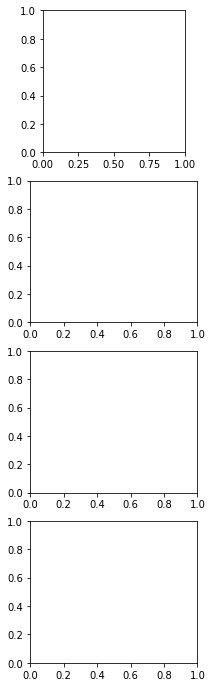

In [66]:
fig, axs = plt.subplots(len(imgs), figsize=(3, 3 * len(imgs)))

for i in range(len(imgs)):
  print(i)
  #axs[i].imshow(imgs[i])

plt.show()   

ValueError: ignored

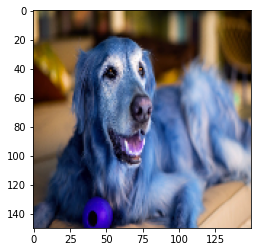

In [20]:
# downscale
img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_NEAREST)

# this is how the input to our model will look like
plt.imshow(img)

print(model.predict([img]))

# Sources

[1] *Xception: Deep Learning with Depthwise Separable Convolutions* by François Chollethttps://arxiv.org/abs/1610.02357

[2] *A Basic Introduction to Seprable Convolutions* by Chi-Feng Wang https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

[3] *Review: Xception* by Sik-Ho Tsang https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568